In [6]:
# Load data file path
data_file = "./data/seattle_listings.csv"

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mart/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# Helper function to extract numbers from strings
def numOnly(strNum):
    if type(strNum)==float:
        return strNum
    return ''.join(filter(lambda x: x.isdigit(), strNum))

In [9]:
# Load and clean raw data
df = pd.read_csv(data_file)
df.columns
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')

In [10]:
# One-hot encode categorical columns
airbnbCat = pd.get_dummies(df, columns=[
    'neighbourhood_group_cleansed',
    'neighbourhood',
    'room_type',
    'property_type'])


In [11]:
# Feature engineering: sentiment and type conversions
airbnbCat['price'] = airbnbCat['price'].astype(float)
airbnbCat['neighborhood_overview'] = airbnbCat['neighborhood_overview'].fillna('')
airbnbCat['neighbourhood_sentiment'] = airbnbCat['neighborhood_overview'].progress_apply(lambda x: vader.polarity_scores(x)['compound'])

100%|██████████| 6883/6883 [00:02<00:00, 2555.88it/s]


In [12]:
# Select relevant features and handle missing values
airBnbDrop = airbnbCat.filter(regex="mumber_of_reviews.*|accommodates|review_scores.*|calculated_host_listings_count.*|reviews_per_month|neighbourhood_group_cleansed_.*|room_type_.*|property_type_.*|bathrooms$|bedrooms$|beds$|price").copy()
airBnbDrop.fillna(0, inplace=True)
airBnbHigh = airBnbDrop[airBnbDrop['price'] > 800]

# Oversampling high-priced listings (not currently used)
# for i in range(100):
#     airBnbDrop.append(airBnbHigh)

# Filtering by price range (not currently used)
# airBnbDrop = airBnbDrop[airBnbDrop['price'] < 800]
# airBnbDrop = airBnbDrop[airBnbDrop['price'] > 50]

# Split features and target
airBnbX = airBnbDrop[airBnbDrop.columns.difference(['price'])]
airBnbY = airBnbDrop['price']


In [13]:
# Train/dev/test split
airBnbX_train, airBnbX_test, airBnbY_train, airBnbY_test = train_test_split(airBnbX, airBnbY, test_size=0.2, random_state=42)
airBnbX_dev, airBnbX_test, airBnbY_dev, airBnbY_test = train_test_split(airBnbX_test, airBnbY_test, test_size=0.5, random_state=42)

In [14]:
# Print shapes of splits
print(airBnbX_train.shape)
print(airBnbY_train.shape)
print(airBnbX_test.shape)
print(airBnbY_test.shape)
print(airBnbX_dev.shape)
print(airBnbY_dev.shape)

(5506, 91)
(5506,)
(689, 91)
(689,)
(688, 91)
(688,)


In [15]:
# Train and evaluate Random Forest Regressor
from sklearn.discriminant_analysis import StandardScaler

model = RandomForestRegressor()
model.fit(airBnbX_train, airBnbY_train)
y_pred_dev = model.predict(airBnbX_dev)

print(f"R^2: {model.score(airBnbX_test, airBnbY_test)}")

R^2: 0.3467692844763277


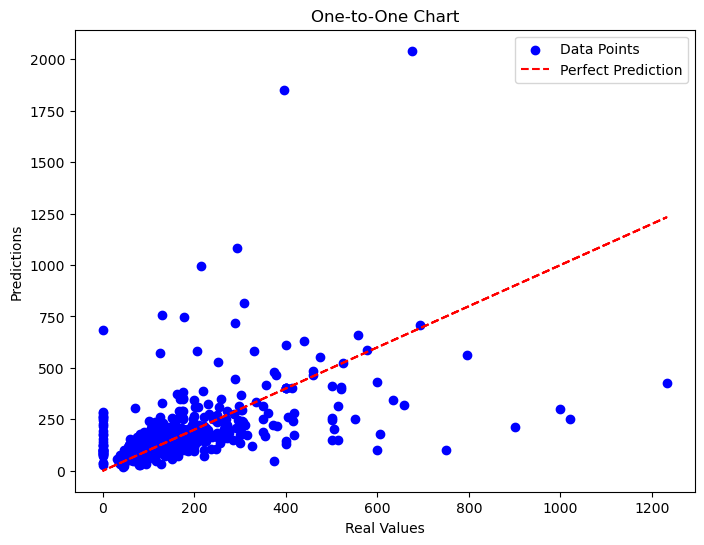

In [16]:
# Plot predictions vs actuals for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(airBnbY_dev, y_pred_dev, color='blue', label='Data Points')
plt.plot(airBnbY_dev, airBnbY_dev, color='red', linestyle='--', label='Perfect Prediction')

plt.title('One-to-One Chart')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.legend()

# plt.grid(True) # Uncomment to show gridlines


Text(0.5, 1.0, 'Visualizing Feature Importances')

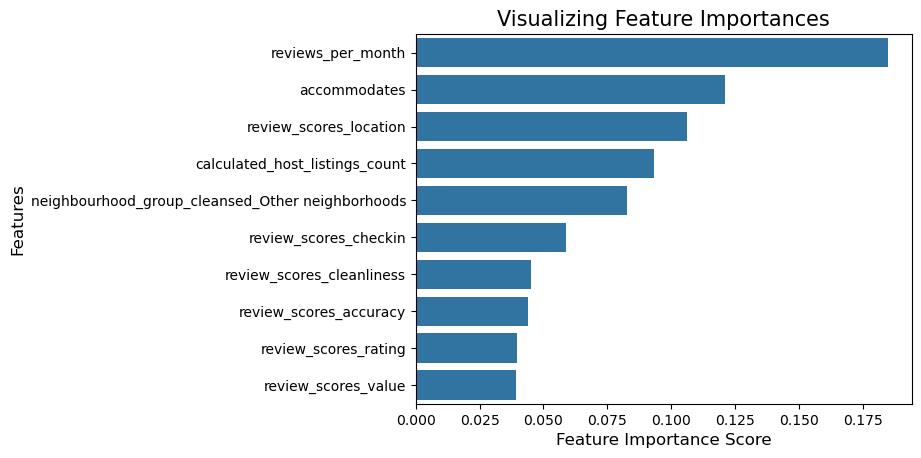

In [17]:
# Feature importance visualization
from sklearn.inspection import permutation_importance
import seaborn as sns
feature_imp = pd.Series(model.feature_importances_,
                        index=airBnbX_test.columns).sort_values(ascending=False)

features_imp_top = feature_imp.head(10)
sns.barplot(x=features_imp_top, y=features_imp_top.index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)


Elapsed time to compute the importances: 15.257 seconds


Text(0, 0.5, 'Features')

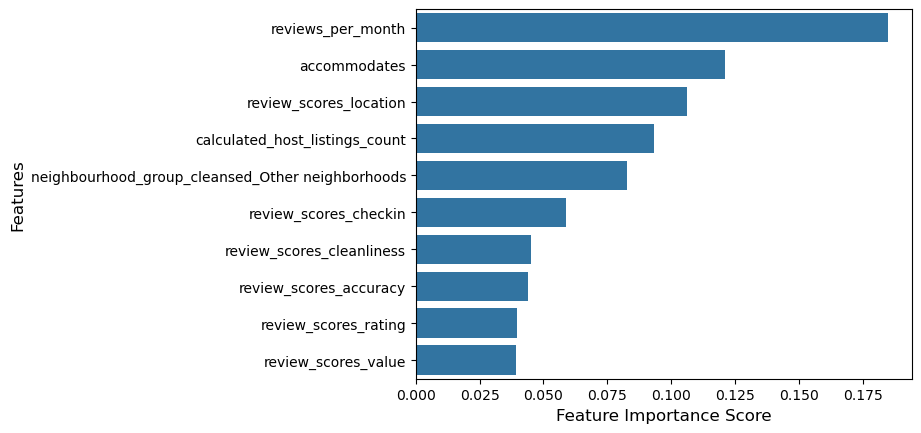

In [18]:
# Permutation importance (Random Forest)
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    model, airBnbX_test, airBnbY_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=airBnbX_test.columns).sort_values(ascending=False)

forest_features_imp_top = feature_imp.head(10)
sns.barplot(x=forest_features_imp_top, y=forest_features_imp_top.index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

In [19]:
# Train and evaluate MLP Regressor (Neural Network)
mlp_regressor = MLPRegressor(hidden_layer_sizes=(16,16,16,16,16), # Two hidden layers, each with 16 neurons
                              activation='relu',  # Activation function for hidden layers
                              solver='adam',  # Optimization solver
                              max_iter=1000,  # Maximum number of iterations
                              random_state=42)  # Random state for reproducibility

mlp_regressor.fit(airBnbX_train, airBnbY_train)

print(f"R^2: {mlp_regressor.score(airBnbX_test, airBnbY_test)}")


R^2: 0.3934108622201814


       accommodates  bathrooms  bedrooms        beds  \
count    689.000000      689.0     689.0  689.000000   
mean       4.169811        0.0       0.0    2.187228   
std        2.676646        0.0       0.0    1.480909   
min        1.000000        0.0       0.0    0.000000   
25%        2.000000        0.0       0.0    1.000000   
50%        4.000000        0.0       0.0    2.000000   
75%        6.000000        0.0       0.0    3.000000   
max       16.000000        0.0       0.0   10.000000   

       calculated_host_listings_count  \
count                      689.000000   
mean                        27.326560   
std                         80.310603   
min                          1.000000   
25%                          1.000000   
50%                          2.000000   
75%                          8.000000   
max                        389.000000   

       calculated_host_listings_count_entire_homes  \
count                                   689.000000   
mean             

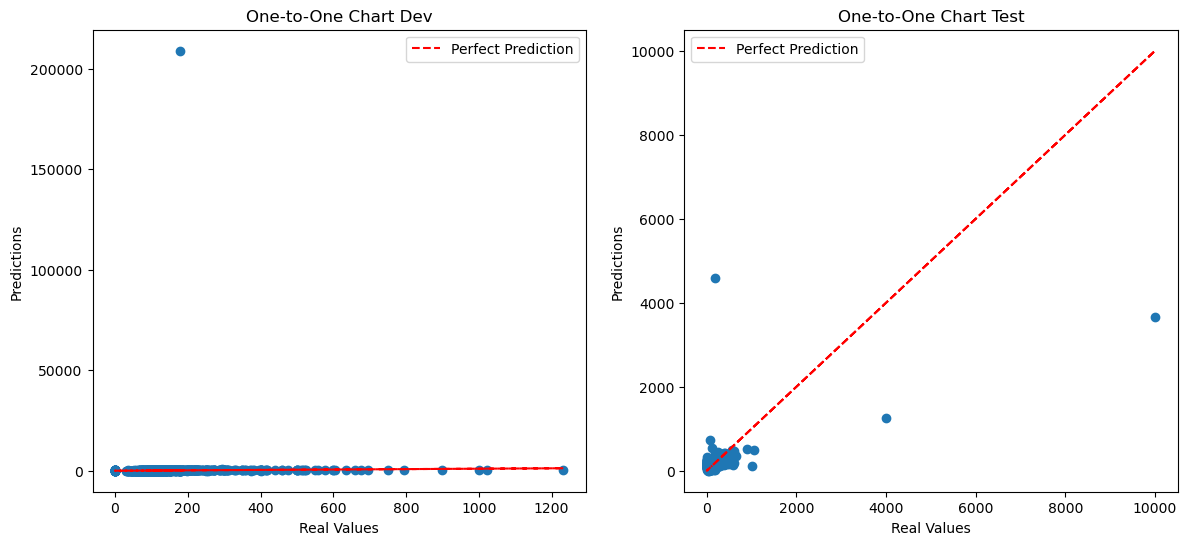

In [20]:
# Predict and plot for MLP Regressor
y_pred_dev = mlp_regressor.predict(airBnbX_dev)
y_pred_test = mlp_regressor.predict(airBnbX_test)
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].scatter(pd.Series(airBnbY_dev),pd.Series(y_pred_dev))
ax[1].scatter(pd.Series(airBnbY_test),pd.Series(y_pred_test))
ax[0].plot(airBnbY_dev, airBnbY_dev, color='red', linestyle='--', label='Perfect Prediction')
ax[1].plot(airBnbY_test, airBnbY_test, color='red', linestyle='--', label='Perfect Prediction')
ax[0].set_title('One-to-One Chart Dev')
ax[0].set_xlabel('Real Values')
ax[0].set_ylabel('Predictions')
ax[0].legend()

ax[1].set_title('One-to-One Chart Test')
ax[1].set_xlabel('Real Values')
ax[1].set_ylabel('Predictions')
ax[1].legend()

print(airBnbX_test.describe()) # Uncomment to show test set statistics